In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf

In [2]:
def bscall(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)

def bsput(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return K*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)

In [3]:
S0 = 1
K = 1
T = 30/365
r = 0.0
sig = 0.2

M = 1000
N = 30

dt = T/N
rdt = r*dt
sigsdt = sig * np.sqrt(dt)

In [4]:
np.random.seed(1234)

S = np.empty([M,N+1])
rv = np.random.normal(r*dt,sigsdt,[M,N])

for i in range(M):
    S[i,0] = S0
    for j in range(N):
        S[i,j+1] = S[i,j] * (1+rv[i,j])

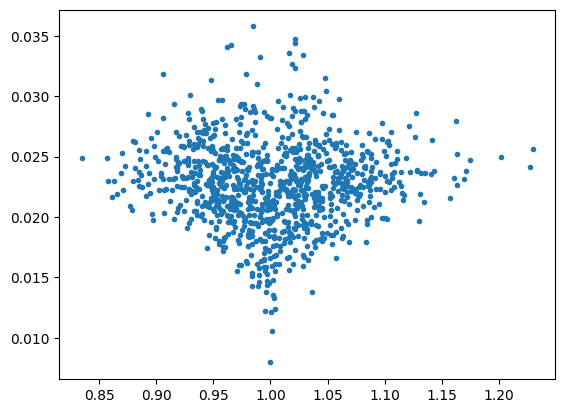

0.02287150628044965

In [5]:
a = []

K = 1

for i in range(M):
  cost= 0
  hedge = 0
  for j in range(N):
    d1 =  (np.log(S[i,j]/K) + (r + 0.5*sig**2)*(T-j*dt))/(sig*np.sqrt(T-j*dt))
    delta = norm.cdf(d1)
    cost = cost + (delta - hedge) * S[i,j]
    hedge = delta
  cost = cost - hedge * S[i,N] + np.maximum(S[i,N]-K,0)
  #cost = cost - hedge * S[i,N]
  a.append(cost)
plt.plot(S[:,-1], a , marker='.', linestyle='')
plt.show()

bscall(S0, K, T, r, sig)


In [6]:
def delta_model(model_name=None):
    price = tf.keras.layers.Input(shape=(1,))

    delta = tf.keras.layers.Dense(32, activation='leaky_relu', use_bias=False)(price)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu', use_bias=False)(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu', use_bias=False)(delta)
    delta = tf.keras.layers.Dense(1, activation='sigmoid')(delta)

    return tf.keras.Model(inputs=price, outputs=delta, name=model_name)

In [7]:
price = tf.keras.layers.Input(shape=(1,), name="price")

my_input = [price]

hedge_cost = tf.keras.layers.Lambda(lambda x: x*0.0)(price)

for j in range(N):
    delta = delta_model(model_name="delta_"+str(j))(price)

    new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j+1))
    my_input += [new_price]

    price_inc = tf.keras.layers.Subtract(name='price_inc_'+str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name="stock_"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_'+str(j))([hedge_cost, cost])

    price = new_price

payoff = tf.keras.layers.Input(shape=(1,), name='payoff')
my_input += [payoff]

cum_cost = tf.keras.layers.Add(name="hedge_cost_plus_payoff")([hedge_cost, payoff])

model = tf.keras.Model(inputs=my_input, outputs=cum_cost)

In [8]:
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
payoff = np.maximum(S[:,-1]-K, 0)
x = [SS] + [payoff]
y = bscall(S0, K, T, r, sig) * np.ones([M,1])
## call option pay off

In [9]:
model.compile(loss='mse', optimizer='adam')


In [10]:
hist = model.fit(x,y, batch_size=32, epochs=200, verbose=True, validation_split=0.2)


Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 123ms/step - loss: 2.6191e-04 - val_loss: 2.8018e-04
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 5.0141e-05 - val_loss: 2.7969e-04
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 2.8235e-05 - val_loss: 2.8024e-04
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.7113e-05 - val_loss: 2.7951e-04
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.1386e-05 - val_loss: 2.7874e-04
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.9373e-05 - val_loss: 2.7645e-04
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.8354e-05 - val_loss: 2.7364e-04
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.2469e-05 - val_loss: 2.7109e-04
Epoch 9/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.8918e-05 - val_loss: 2.6790e-04
Epoch 10/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.3933e-05 - val_loss: 2.5984e-04
Epoch 11/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - lo

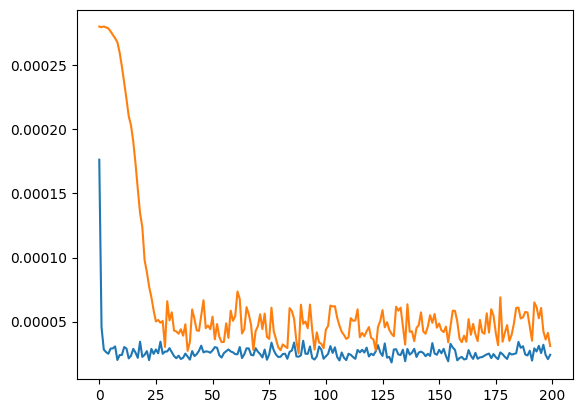

In [11]:
plt.plot(hist.history['loss'],)
plt.plot(hist.history['val_loss'],)
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step


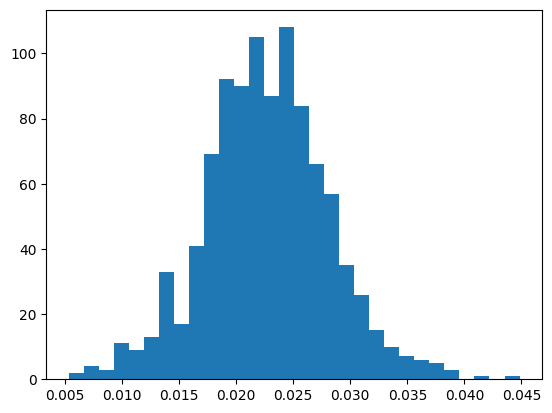

In [12]:
plt.hist(model.predict(x), bins=30)
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


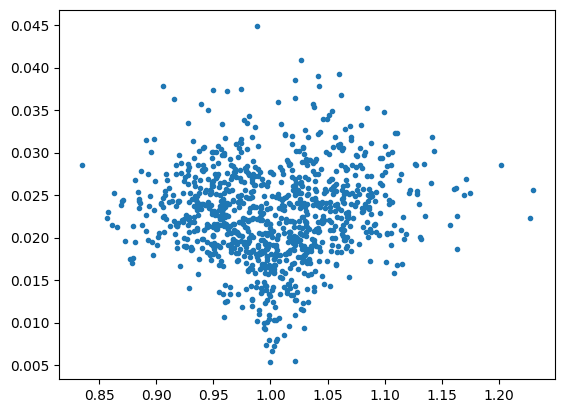

In [13]:
plt.plot(S[:,-1], model.predict(x), marker = ".", linestyle='none')
plt.show()

In [16]:
def submodel(m=model):
    submodel_input = m.get_layer("delta_3").input
    submodel_output = m.get_layer("delta_3")(submodel_input)

    return tf.keras.Model(inputs=submodel_input, outputs=submodel_output)

In [17]:
submodel(model)(np.linspace(0.9,1.1,10))

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.01813285],
       [0.06234814],
       [0.18626839],
       [0.33659068],
       [0.40662488],
       [0.70716023],
       [0.87993306],
       [0.95169234],
       [0.9803361 ],
       [0.9936671 ]], dtype=float32)>

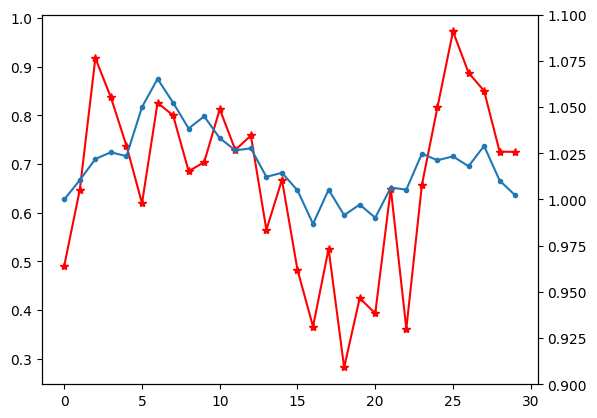

In [18]:
scenario = 12
b = []
for j in range(N):
    a = model.get_layer("delta_"+str(j))(S[scenario,j].reshape(1,1))
    b.append(a.numpy().reshape(1,))

b
fig,ax = plt.subplots()
ax.plot(b, marker="*", color='r')
ax2 = ax.twinx()
ax2.plot(S[scenario,:-1], marker=".",)
ax2.set_ylim(0.9,1.1)
plt.show()

In [19]:
def rnn_delta_model(model_name=None, num=1):
    price = tf.keras.layers.Input(shape=(num,1))
    delta = tf.keras.layers.GRU(32, return_sequences=True)(price)
    delta = tf.keras.layers.GRU(32)(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu', use_bias=False)(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu', use_bias=False)(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu', use_bias=False)(delta)
    delta = tf.keras.layers.Dense(1, activation='sigmoid')(delta)

    return tf.keras.Model(inputs=price, outputs=delta, name=model_name)


In [22]:
rnn_delta_model(num=100).summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)          │ (None, 100, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 100, 32)             │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 32)                  │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_128 (Dense)                    │ (None, 32)                  │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_64               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_129 (Dense)                    │ (None, 32)                  │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_65               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_130 (Dense)                    │ (None, 32)                  │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_131 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,057 (51.00 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 128 (512.00 B)

In [23]:

price = tf.keras.layers.Input(shape=(1,), name="price")

my_input = [price]

hedge_cost = tf.keras.layers.Lambda(lambda x: x*0.0)(price)

price_set = tf.keras.layers.Concatenate()([price, price])

for j in range(N):
    delta = rnn_delta_model(model_name="delta_"+str(j), num=2+j)(price_set)

    new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j+1))
    my_input += [new_price]

    price_inc = tf.keras.layers.Subtract(name='price_inc_'+str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name="stock_"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_'+str(j))([hedge_cost, cost])

    price_set = tf.keras.layers.Concatenate()([price_set, new_price])

    price = new_price

payoff = tf.keras.layers.Input(shape=(1,), name='payoff')
my_input += [payoff]

cum_cost = tf.keras.layers.Add(name="hedge_cost_plus_payoff")([hedge_cost, payoff])

model = tf.keras.Model(inputs=my_input, outputs=cum_cost)

In [24]:
model.compile(loss='mse', optimizer='adam')
hist = model.fit(x,y, batch_size=32, epochs=50, verbose=True, validation_split=0.2)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - loss: 2.3347e-04 - val_loss: 2.7577e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 356ms/step - loss: 5.3854e-05 - val_loss: 2.7699e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 410ms/step - loss: 3.9845e-05 - val_loss: 2.7763e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 429ms/step - loss: 3.6381e-05 - val_loss: 2.7700e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 363ms/step - loss: 3.6060e-05 - val_loss: 2.7866e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 435ms/step - loss: 2.8493e-05 - val_loss: 2.7241e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 439ms/step - loss: 2.5233e-05 - val_loss: 2.7240e-04
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 377ms/step - loss: 3.3401e-05 - val_loss: 2.8534e-04
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 446ms/step - loss: 3.3830e-05 - val_loss: 2.8103e-04
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 429ms/step - loss: 4.0076e-05 - val_loss: 2.7568e-04
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 365ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 606ms/step


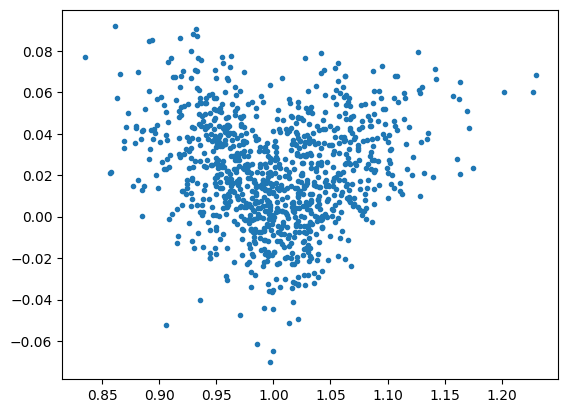

In [25]:
plt.plot(S[:,-1], model.predict(x), marker = ".", linestyle='none')
plt.show()